In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import time
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.pipeline import make_pipeline
from sklearn.datasets import make_blobs

from sklearn import feature_selection
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.pipeline import Pipeline

from pmlb import fetch_data

#### Please note that this dataset includes keywords ONE YEAR from procedure confirmation time

In [ ]:
test_df = pd.read_csv('keywords_count_2019_0122.csv')

In [3]:
test_df.head()

,MRN,DateProcConfirmed,Guidelines,claudicat_+,claudicat_-,disc degen_+,disc degen_-,myelopath_+,myelopath_-,widen_+,...,signal change_+,signal change_-,fell_+,fell_-,fall_+,fall_-,unstable_+,unstable_-,fracture_+,fracture_-
0,266227,2018-02-14,Myelopathy,0.0,0.0,0.0,0.0,3.0,2.0,0.0,...,0.0,0.0,2.0,0.0,2.0,2.0,0.0,0.0,1.0,8.0
1,311618,2017-05-24,Radiculopathy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,4.0,0.0,0.0,0.0,0.0,2.0
2,421705,2017-08-04,Radiculopathy,0.0,10.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,10.0,0.0,0.0,0.0,1.0
3,430919,2017-11-28,Radiculopathy,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0
4,465146,2018-08-22,Radiculopathy,0.0,1.0,0.0,0.0,0.0,7.0,0.0,...,0.0,0.0,1.0,0.0,1.0,4.0,0.0,0.0,24.0,0.0


Taking a look at the outcomes we are trying to predict

In [4]:
set(list(test_df['Guidelines']))

{'Deformity',
 'Deformity (kyphosis, head-drop syndrome, post-lami deformity)',
 'Discogenic axial neck pain',
 'Myelopathy',
 'Non-traumatic instability',
 'Pseudoarthrosis',
 'Radiculopathy',
 'Traumatic injury'}

In [5]:
test_df['Guidelines'].value_counts()

Myelopathy                                                       61
Radiculopathy                                                    54
Traumatic injury                                                  3
Pseudoarthrosis                                                   3
Deformity                                                         1
Non-traumatic instability                                         1
Deformity (kyphosis, head-drop syndrome, post-lami deformity)     1
Discogenic axial neck pain                                        1
Name: Guidelines, dtype: int64

In [ ]:
test_df['Guidelines_class'] = 1
test_df['Guidelines_class'][test_df['Guidelines']=='Myelopathy'] = 2
test_df['Guidelines_class'][test_df['Guidelines']=='Radiculopathy'] = 3

In [7]:
test_df['Guidelines_class'].value_counts()

2    61
3    54
1    10
Name: Guidelines_class, dtype: int64

In [8]:
X_train = test_df.iloc[:,3:-1]
y_train = test_df.iloc[:,-1]

## Multinomial Logistic Regression

1. Classic multinomial logistic regression. No polynomial terms.
Firstly, 19 features that contribute most to the model are selected via the 'selector' method.

In [9]:
from sklearn.feature_selection import RFE

lrm_ovr = LogisticRegressionCV(multi_class = 'ovr', cv=3)
selector = RFE(lrm_ovr, 19)

In [10]:
selector = selector.fit(X_train, y_train)
selector.support_ 

array([False, False, False, False,  True, False,  True, False,  True,
       False, False,  True, False, False,  True,  True, False, False,
        True, False, False,  True,  True,  True,  True, False,  True,
       False, False, False, False, False,  True, False, False, False,
       False, False, False, False,  True, False,  True, False, False,
       False, False, False,  True, False,  True,  True, False, False,
        True, False])

#### These variables seem to be contributing the most to the model

In [11]:
X_train.columns[selector.support_]

Index(['myelopath_+', 'widen_+', 'neck pain_+', 'shoulder pain_-', 'injury_+',
       'injury_-', 'sublux_+', 'weakness_-', 'stenosis_+', 'stenosis_-',
       'radicul_+', 'radiat_+', 'myelomala_+', 'spondylosis_+',
       'paresthesia_+', 'fell_+', 'fall_+', 'fall_-', 'fracture_+'],
      dtype='object')

In [28]:
lrm_ovr = LogisticRegressionCV(multi_class = 'ovr', cv=3).fit(X_train.iloc[:,selector.support_], y_train)


print('OvR Logistic Regression: accuracy on train={:.2%}, cross validation score={:.2%}'.format(
    lrm_ovr.score(X_train.iloc[:,selector.support_], y_train),cross_val_score(lrm_ovr,X_train.iloc[:,selector.support_],y_train,cv=3).mean()))

OvR Logistic Regression: accuracy on train=79.20%, cross validation score=64.87%


#### Even on the listed amount of data we have, the training dataset accuracy still reached nearly 80%! And the cross validation score can be improved if we have more data.

In [34]:
#Plot number of features selected against accuracy and cv score
cvscores = []
accuracy = []
n_selector = []
for i in range(12,25):
    
    lrm_ovr = LogisticRegressionCV(multi_class = 'ovr', cv=3)
    selector = RFE(lrm_ovr, i)
    selector = selector.fit(X_train, y_train)
    lrm_ovr = LogisticRegressionCV(multi_class = 'ovr', cv=3).fit(X_train.iloc[:,selector.support_], y_train)
    
    cvscores.append(cross_val_score(lrm_ovr,X_train.loc[:,selector.support_],y_train,cv=3).mean())
    accuracy.append(lrm_ovr.score(X_train.loc[:,selector.support_],y_train))
    n_selector.append(i)

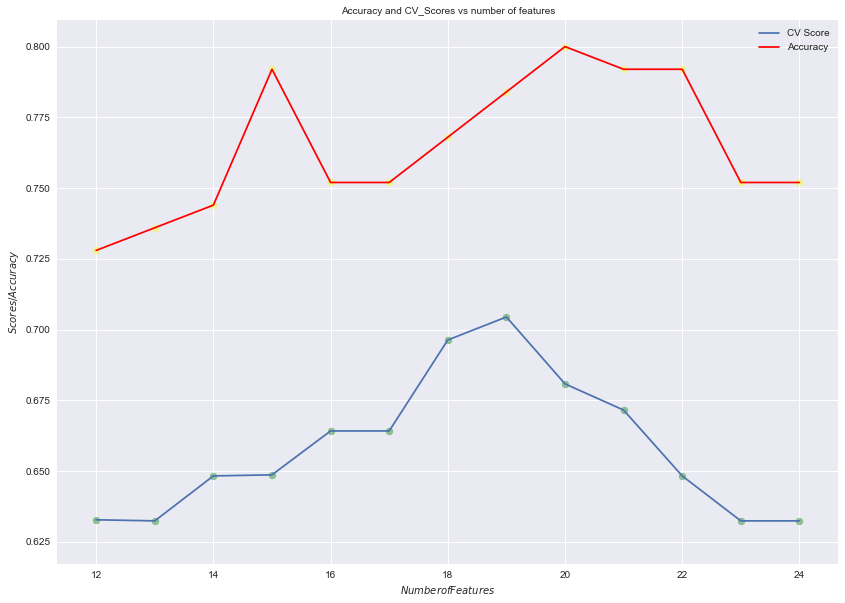

In [35]:
SIZE=10
fig, ax = plt.subplots(1,1, figsize=(14,10))

ax.scatter(n_selector,cvscores,color='green',alpha=0.4)
ax.plot(n_selector,cvscores,label='CV Score')

ax.scatter(n_selector,accuracy,color='yellow',alpha=0.4)
ax.plot(n_selector,accuracy,color='red',label='Accuracy')
# Set title
ax.set_title('Accuracy and CV_Scores vs number of features', fontsize=SIZE)
# Create labels
ax.set_xlabel('$Number of Features$', fontsize=SIZE)
ax.set_ylabel('$Scores/Accuracy$', fontsize=SIZE)
ax.tick_params(labelsize=SIZE)
ax.legend(loc='best',fontsize=SIZE)

As can be seen above, Including the top 19 features gives the model the most optimal performance - Highest cross-validation score and accuracy score.

2. MLR with 2nd degree poly-terms

In [66]:
polynomial_logreg_estimator = make_pipeline(
    PolynomialFeatures(degree=2, include_bias=False),
    LogisticRegressionCV(multi_class="ovr",cv=3))
lrm_poly = polynomial_logreg_estimator.fit(X_train, y_train)
selector = RFE(lrm_ovr, 15)
selector = selector.fit(X_train, y_train)
selector.support_ 

array([False, False, False, False,  True, False, False, False,  True,
       False, False,  True, False, False, False,  True, False, False,
        True, False, False,  True,  True,  True,  True, False,  True,
       False, False, False, False, False,  True, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False, False, False,  True, False, False,  True, False, False,
        True, False])

In [67]:
polynomial_logreg_estimator = make_pipeline(
    PolynomialFeatures(degree=2, include_bias=False),
    LogisticRegressionCV(multi_class="ovr",cv=3))
lrm_poly = polynomial_logreg_estimator.fit(X_train.iloc[:,selector.support_], y_train)
print('OvR Logistic Regression Quad&Interaction: accuracy on train={:.2%}, cross validation score={:.2%}'.format(
    lrm_poly.score(X_train.iloc[:,selector.support_], y_train), cross_val_score(lrm_poly,X_train.iloc[:,selector.support_],y_train,cv=3).mean()))

OvR Logistic Regression Quad&Interaction: accuracy on train=84.00%, cross validation score=68.01%


In [53]:
#Plot number of features selected against accuracy and cv score?
cvscores = []
accuracy = []
n_selector = []
for i in range(12,25):
    polynomial_logreg_estimator = make_pipeline(PolynomialFeatures(degree=2, include_bias=False), LogisticRegressionCV(multi_class="ovr",cv=3))
    lrm_poly = polynomial_logreg_estimator.fit(X_train,y_train)
    
    selector = RFE(lrm_ovr, i)
    selector = selector.fit(X_train, y_train)
    
    lrm_poly = polynomial_logreg_estimator.fit(X_train.iloc[:,selector.support_], y_train)
    
    cvscores.append(cross_val_score(lrm_poly,X_train.loc[:,selector.support_],y_train,cv=3).mean())
    accuracy.append(lrm_poly.score(X_train.loc[:,selector.support_],y_train))
    n_selector.append(i)

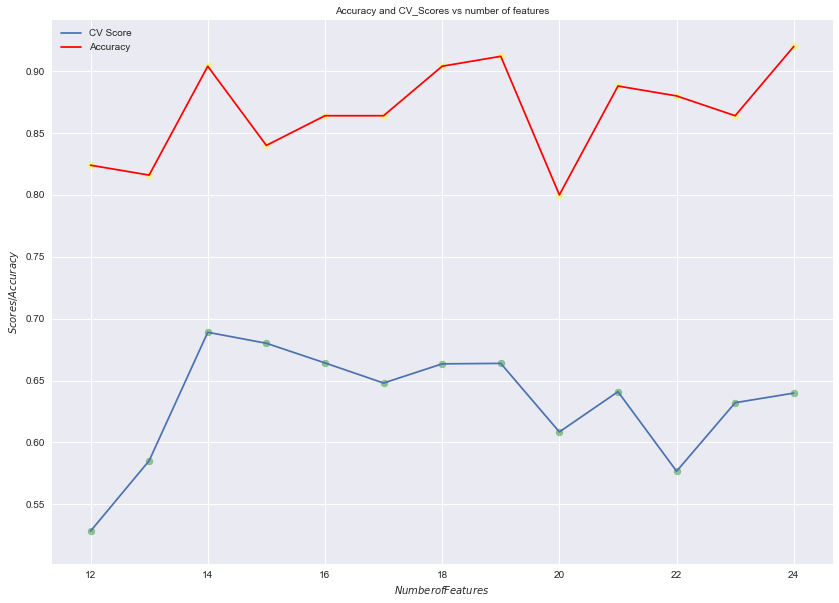

In [54]:
SIZE=10
fig, ax = plt.subplots(1,1, figsize=(14,10))

ax.scatter(n_selector,cvscores,color='green',alpha=0.4)
ax.plot(n_selector,cvscores,label='CV Score')

ax.scatter(n_selector,accuracy,color='yellow',alpha=0.4)
ax.plot(n_selector,accuracy,color='red',label='Accuracy')
# Set title
ax.set_title('Accuracy and CV_Scores vs number of features', fontsize=SIZE)
# Create labels
ax.set_xlabel('$Number of Features$', fontsize=SIZE)
ax.set_ylabel('$Scores/Accuracy$', fontsize=SIZE)
ax.tick_params(labelsize=SIZE)
ax.legend(loc='best',fontsize=SIZE)

Features = 14 is the best. However, this model in general provides Low CV scores. It is not as generalizable as the logistic regression model without polynomial features. Overall, not recommended


## LDA & QDA

In [70]:
lda = LinearDiscriminantAnalysis(store_covariance=True)#, priors=[1,1,1])
qda = QuadraticDiscriminantAnalysis(store_covariance=True)#, priors=[1,1,1])

t = time.time()
lda.fit(X_train.iloc[:,selector.support_] , y_train)
fittime_lda = time.time()-t

t = time.time()
qda.fit(X_train.iloc[:,selector.support_], y_train)
fittime_qda = time.time()-t


print('LDA accuracy train={:.2%}, LDA cv score={:.2%},fit time {:.2f}s'.format(
    lda.score(X_train.iloc[:,selector.support_], y_train), cross_val_score(lda,X_train.iloc[:,selector.support_],y_train,cv=3).mean(),fittime_lda))
print('QDA accuracy train={:.2%}, QDA cv score={:.2%},fit time {:.2f}s'.format(
    qda.score(X_train.iloc[:,selector.support_], y_train),cross_val_score(qda,X_train.iloc[:,selector.support_],y_train,cv=3).mean(), fittime_qda))

LDA accuracy train=68.80%, LDA cv score=68.01%,fit time 0.01s
QDA accuracy train=73.60%, QDA cv score=57.70%,fit time 0.00s


/Users/lucyliu/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/lucyliu/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/lucyliu/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/lucyliu/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [ ]:
#Plot number of features selected against accuracy and cv score?
cvscores = []
accuracy = []
n_selector = []
for i in range(20,40):
    
    lda = LinearDiscriminantAnalysis(store_covariance=True)#, priors=[1,1,1])
    selector = RFE(lda, i)
    selector = selector.fit(X_train, y_train)
    
    lda = lda.fit(X_train.iloc[:,selector.support_] , y_train)

    cvscores.append(cross_val_score(lda,X_train.loc[:,selector.support_],y_train,cv=3).mean())
    accuracy.append(lda.score(X_train.loc[:,selector.support_],y_train))
    n_selector.append(i)



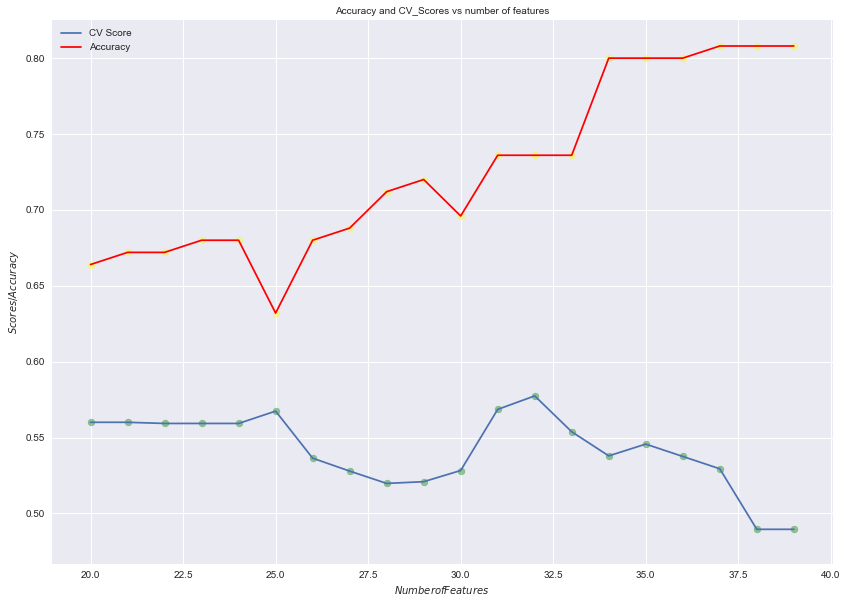

In [75]:
SIZE=10
fig, ax = plt.subplots(1,1, figsize=(14,10))

ax.scatter(n_selector,cvscores,color='green',alpha=0.4)
ax.plot(n_selector,cvscores,label='CV Score')

ax.scatter(n_selector,accuracy,color='yellow',alpha=0.4)
ax.plot(n_selector,accuracy,color='red',label='Accuracy')
# Set title
ax.set_title('Accuracy and CV_Scores vs number of features', fontsize=SIZE)
# Create labels
ax.set_xlabel('$Number of Features$', fontsize=SIZE)
ax.set_ylabel('$Scores/Accuracy$', fontsize=SIZE)
ax.tick_params(labelsize=SIZE)
ax.legend(loc='best',fontsize=SIZE)

**I would not recommend using LDA or QDA for this purpose. It can be seen from the graph above that though they perform well on the training set, They are too 'flexible' and obviously tends to overfit. This resulted in a very bad CV score. The reason behind this is due to the fact that our dataset is very small, and they would perform better on larger datasets. It is also very difficult to perform feature selection on them, since they are sort of built to fit from as many features as possible...**

# Decision Trees

Fit the tree over many depths, then visualize

In [81]:
cvscores = []
accuracy = []
max_depth = []
for i in range(2,11):
    clf = DecisionTreeClassifier(max_depth=i)
    clf.fit(X_train,y_train)
    cvscores.append(cross_val_score(clf,X_train,y_train,cv=3).mean())
    accuracy.append(clf.score(X_train,y_train))
    max_depth.append(i)

In [82]:
selector.support_

array([ True,  True,  True,  True, False,  True,  True,  True, False,
        True, False,  True,  True, False,  True,  True,  True, False,
        True,  True, False,  True, False, False, False,  True, False,
        True,  True,  True,  True, False,  True,  True, False,  True,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True, False, False,  True,  True,
        True, False])

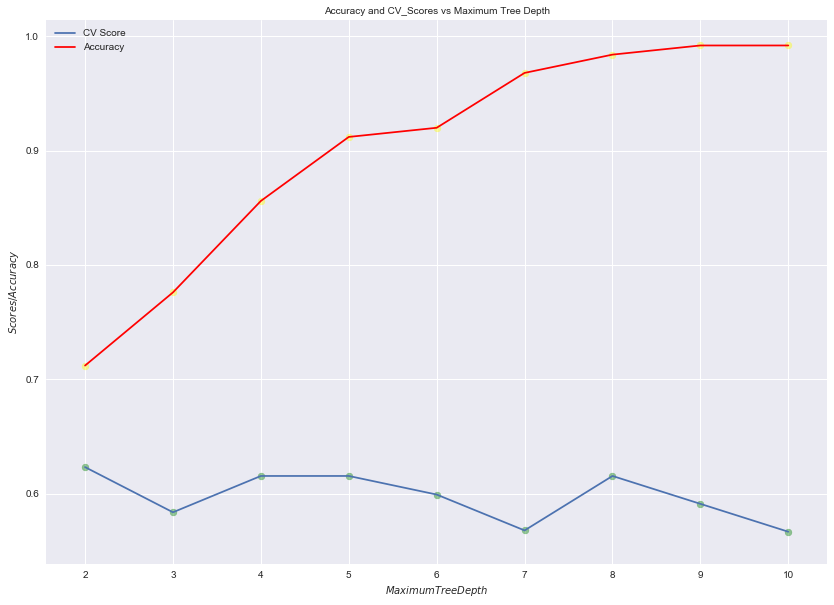

In [83]:
SIZE=10
fig, ax = plt.subplots(1,1, figsize=(14,10))

ax.scatter(max_depth,cvscores,color='green',alpha=0.4)
ax.plot(max_depth,cvscores,label='CV Score')

ax.scatter(max_depth,accuracy,color='yellow',alpha=0.4)
ax.plot(max_depth,accuracy,color='red',label='Accuracy')
# Set title
ax.set_title('Accuracy and CV_Scores vs Maximum Tree Depth', fontsize=SIZE)
# Create labels
ax.set_xlabel('$Maximum Tree Depth$', fontsize=SIZE)
ax.set_ylabel('$Scores/Accuracy$', fontsize=SIZE)
ax.tick_params(labelsize=SIZE)
ax.legend(loc='best',fontsize=SIZE)

**The decision tree performs really well for the training data. This is expected, as all decision tree's accuracies are like this. However, the problem with decision trees is that they are not really 'model based'. So here, strongly not recommended...**

**Also please note that I did not try neural networks because we only have about 100 data points... If we had more data, neural networks would be a very good approach to try out**

### All in all, I believe that the classic logistic regression model would be able to achieve the most satisfactory results with the data we currently have. The other models would not be able to function well do to the fact that they generally work better with larger datasets. And also, It seems that our features are not good enough (even after a round of feature selections). This is mainly due to the fact that our feature matrix is very sparse.##